# Co-refinement of ellipsometry and neutron reflectometry data

This is a demonstration of how to co-refine data obtained from both ellipsometry and neutron reflectometry using both *refellips* and *refnx*.

The data analysed in this demonstration corresponds to a polymer film grafted onto an oxidised silicon wafer. Both ellipsometry and neutron reflectometry were performed at ANSTO using an Accurion EP4 and the *Platypus* neutron reflectometer, respectively.

We begin by loading the relevant packages.

In [1]:
%matplotlib inline
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import refnx
from refnx.dataset import ReflectDataset as RD
from refnx.analysis import (
    Transform,
    CurveFitter,
    Objective,
    GlobalObjective,
    Parameter,
)
from refnx.reflect import SLD, ReflectModel

In [3]:
import refellips
from refellips.dataSE import open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.structureSE import load_material

In [4]:
print(
    f"refnx: {refnx.version.version}\nrefellips: {refellips.version.version}\nscipy: {scipy.version.version}\nnumpy: {np.version.version}"
)

refnx: 0.1.27
refellips: 0.0.1.dev0+504eb3d
scipy: 1.8.0
numpy: 1.22.3


Here we load in the neutron reflectometry data (using `RD`) and the ellipsometry data (using `open_EP4file`) to be co-refined.

In [5]:
# Load in the NR data
data_nr = RD("corefine_polyBrush_nr.dat")

# Load in the ellipsometry data
data_ellips = open_EP4file("corefine_polyBrush_ellipsometry.dat")

No time data.
Treating as single location


In order to perform the co-refinement, we will make global parameters for the thickness of the silica and polymer layers to use in both the neutron reflectometry and ellipsometry models.

In [6]:
silica_thickness = Parameter(
    20, vary=True, bounds=(1, 30), name="silica_thickness"
)
polymer_thickness = Parameter(
    250, vary=True, bounds=(150, 400), name="polymer_thickness"
)

### Make the NR model

We start by creating `SLD` objects to describe the SLD of each material.

In [7]:
air = SLD(0, "air")
polymer = SLD(0.8, "polymer")
sio2 = SLD(3.47, "sio2")
si = SLD(2.07, "si")

Set the thickness value and bounds for the silica and polymer layer.

In [8]:
sio2_l = sio2(silica_thickness)

polymer_layer = polymer(polymer_thickness)
polymer_layer.sld.real.setp(vary=True, bounds=(0.50, 1.0))

Establish the interface layer structure: fronting to backing.

In [9]:
structure_nr = air | polymer_layer | sio2_l | si
structure_nr.contract = 1.5

Create the NR model (using `ReflectModel`) and set the scale & background

In [10]:
model_nr = ReflectModel(structure_nr)
model_nr.bkg.setp(vary=True, bounds=(0, 5e-6))
model_nr.scale.setp(vary=True, bounds=(0.7, 1.2))

Create the NR `Objective`

In [11]:
objective_nr = Objective(
    model_nr, data_nr, use_weights=False, transform=Transform("logY")
)

### Make the ellipsometry model 

The ellipsometry model and objective are created in an analogous fashion to NR. Dispersion curves to describe a material are loaded using `load_material` and the model & objective are created using the `ReflectModelSE` and `ObjectiveSE` in *refellips*, respectively.

In [12]:
si = load_material("silicon")
sio2 = load_material("silica")
PNIPAM = load_material("pnipam")
air = load_material("air")

polymer_layer = PNIPAM(polymer_thickness)
polymer_layer.name = "PNIPAM"

silica_layer = sio2(silica_thickness)
silica_layer.name = "Silica"

structure_ellips = air() | polymer_layer | silica_layer | si()
structure_ellips.contract = 1.5

model_ellips = ReflectModelSE(structure_ellips)

objective_ellips = ObjectiveSE(model_ellips, data_ellips, use_weights=False)

### The global objective

We now form a `GlobalObjective` from the individual `Objective`s. This means that both objectives are analysed together: co-refinement.

In [13]:
global_objective = GlobalObjective([objective_nr, objective_ellips])

### Fitting the data

Create the `CurveFitter` and fit with differential evolution.

In [14]:
fitter = CurveFitter(global_objective)
fitter.fit("differential_evolution", target="nll");

26it [00:03,  7.10it/s]


### Plot the results

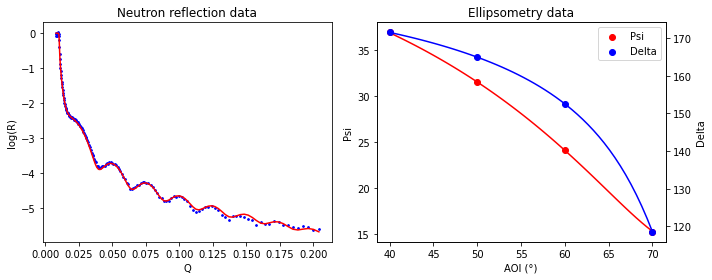

In [15]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
objective_nr.plot(fig=fig)
ax1.set_xlabel("Q")
ax1.set_ylabel("log(R)")
ax1.set_title("Neutron reflection data")

ax2 = fig.add_subplot(122)
objective_ellips.plot(fig=fig)
ax2.set_title("Ellipsometry data")

fig.tight_layout()

In [16]:
print(global_objective)

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 140361174869616
Dataset = corefine_polyBrush_nr
datapoints = 166
chi2 = 0.2675882519935612
Weighted = False
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.990832 +/- 0.014, bounds=[0.7, 1.2]>
<Parameter:     'bkg'     , value=3.80118e-07 +/- 7.44e-08, bounds=[0.0, 5e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
__________________________________________